# Genshin Impact Google Play Sentiment Reviews

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/genshin_review.csv")
df

,review,rating
0,Absolute Masterpiece i hate the people who gav...,5
1,amazing but the fandom isn't amazing,5
2,Very nice,5
3,Give me gambling money (primo gems),4
4,"This is one my first Open World RPG games, and...",4
...,...,...
990,Yeah,4
991,Getting bored,3
992,This game sucks,1
993,"""If Adventuring in Teyvat was a dream, Genshin...",5


# Check for Nulls and Dupes

In [4]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: review    0
rating    0
dtype: int64
Dupe Count: 47


In [5]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=5, Count=514, Percentage=54.219%
Class=4, Count=100, Percentage=10.549%
Class=1, Count=230, Percentage=24.262%
Class=2, Count=46, Percentage=4.852%
Class=3, Count=58, Percentage=6.118%


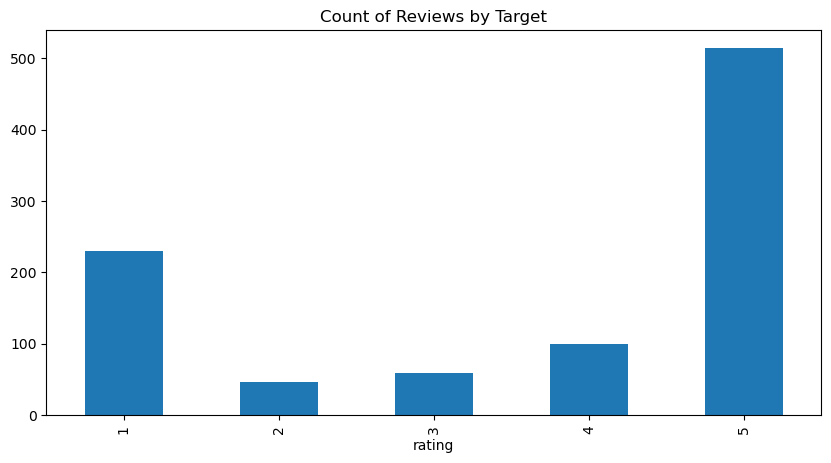

In [6]:
check_class_imbalance(df, df["rating"], "rating")

# Multi Classification problems are difficult for models, we can turn this into a binary problem